In [2]:
!pip install datasets==2.19.1 transformers==4.42.0 torch scikit-learn==1.3.2 evaluate==0.4.3 numpy==1.24.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 129.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.

In [3]:
!pip install --upgrade numpy==1.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 111.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.


## **1. Problem Recap and Dataset Description**

* **Group ID:** `GROUP2`
* **Dataset and Modality:**
  * The dataset used is **Stanford Question Answering Dataset (SQuAD) 2.0**. Its modality is **text**.
  * It is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.
  * To do well on SQuAD2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.
* **Supervised Learning Task:**
  * The task is **Extractive Question Answering (QA)**, a supervised learning problem.
  * Given a context passage and a question, the model must predict the span of text within the context that answers the question.
  * If the question is unanswerable based on the context, the model should indicate this.
* **Target Variable(s) and Output Modeling:**
  * The primary target variables are the **start and end token indices** of the answer span within the tokenized context.
  * For answerable questions, the model predicts the index of the first token of the answer (`start_position`) and the index of the last token of the answer (`end_position`).
  * For unanswerable questions, the target `start_position` and `end_position` are both set to index `0`. The model is trained to predict `(0, 0)` in these cases.
  * The model output consists of two sets of logits, one for the start position and one for the end position, across all tokens in the input sequence. The predicted indices are obtained by taking the `argmax` of these logits.
* **Why this dataset is meaningful, interesting, or challenging**
  * **Meaningful:** SQuAD is a widely recognized benchmark for reading comprehension and Question Answering. Success on SQuAD often translates to better performance on real-world information retrieval and conversational AI tasks.
  * **Interesting:** It directly tests a model's ability to understand context, locate relevant information, and perform reasoning based on textual evidence.
  * **Challenging:**
    * **Unanswerable Questions:** SQuAD v2 introduces the significant challenge of identifying when a question *cannot* be answered from the context, requiring the model not just to extract but also to abstain. This mirrors real-world scenarios where information might be missing.
    * **Context Length:** Passages can be long, requiring models that can handle longer sequences.
    * **Subtle Reasoning:** Some questions require nuanced understanding and reasoning beyond simple keyword matching.

### **1.1 Importing necessary libraries**

In [1]:
# Importing Required Libraries
import os
import re
import torch
from datasets import load_dataset, load_from_disk, DatasetDict
from torch.utils.data import DataLoader, Subset
import torch.optim as optim

from transformers import AutoTokenizer, DistilBertForQuestionAnswering, AdamW, get_linear_schedule_with_warmup
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import numpy as np

import evaluate
from tqdm.auto import tqdm
import collections
import random

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
MODEL_CHECKPOINT = "distilbert-base-cased" # Using DistilBERT
MAX_LENGTH = 384  # Max sequence length for tokenizer
STRIDE = 128      # Overlap stride for long contexts
BATCH_SIZE = 32   # Adjusted batch size (DistilBERT uses less memory)
LEARNING_RATE = 2e-5 # Common LR for DistilBERT fine-tuning
WEIGHT_DECAY = 0.1
MAX_GRAD_NORM = 1.0
NUM_EPOCHS = 10
N_BEST_SIZE = 20  # For postprocessing: consider top N start/end logits
MAX_ANSWER_LENGTH = 30 # For postprocessing: maximum length of predicted answer tokens
BEST_MODEL_PATH = "best_distilbert_squad_v2_model.bin"
EARLY_STOPPING_PATIENCE = 3

# SQuAD v2 Metric
squad_v2_metric = evaluate.load("squad_v2")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## **2. Model Finalization and Pipeline Design**

Here, we are trying to load and process the data set. Once processed, training and evaluation loop has been created accordingly. The model choosen is a Multi-Layer Perceptron model (MLP), where we are tyring to figure out the optimal number of layers and neurons.

We have refined the pipeline using DistilBERT, a distilled version of BERT, and establish a robust evaluation process including F1 score.

### **2.1 Data Preparation Overview:**

This code snippet handles the essential task of taking the raw SQuAD v2 question-answering dataset and transforming it into a format that our deep learning model can understand and learn from. It is similar to translating human language and structure into the model's language of numbers and specific formats.

**1. Load the Translator (Tokenizer):**
* First, we load a special tool called a `tokenizer` (`AutoTokenizer`). This tokenizer is specifically designed for the `distilbert-base-cased` model we plan to use.

* Its main job is to break down sentences into smaller pieces (words or sub-words) called "tokens" and convert these tokens into unique numerical IDs.

**2. Clean Up the Text:**
* Real-world text can be messy (e.g., extra spaces). The `clean_text` function tidies this up by removing extra whitespace from the beginning, end, and middle of the text passages (contexts) and questions.
* The `apply_clean_text` function applies this cleaning consistently to all questions and contexts in the dataset using the efficient `.map()` method. It keeps track of the original IDs and answers associated with each example.

**3. Tokenize and Format for the Model:**
* This is the most involved step, handled by `preprocess_squad_examples`. It takes the cleaned questions and contexts and prepares them for the model:
  * **Combine & Tokenize:** It feeds pairs of questions and contexts to the tokenizer.
  * **Handle Long Texts:** Context passages in SQuAD can be very long, often longer than the model can handle at once (`MAX_LENGTH`). The code deals with this using:
    * `truncation="only_second"`: If a combined question-context is too long, it only shortens (truncates) the context part.
    * `stride`: To avoid losing information near the truncation point, it creates overlapping chunks. If a context is split, the next chunk starts `STRIDE` tokens before the previous one ended.
    * `return_overflowing_tokens=True`: This tells the tokenizer to actually generate these multiple chunks (features) from a single long example.
  * **Padding:** Ensures all processed sequences have the exact same length (`MAX_LENGTH`) by adding special "padding" tokens if they are too short.
  * **Map Answers to Tokens:** This is crucial. The original dataset tells us the answer's start position in *characters*. The model, however, needs to predict the start and end *token* indices. This function calculates these target `start_positions` and `end_positions`.
    * It uses `offset_mapping` (which tells us the start/end character position of each token) and `sequence_ids` (which tells us if a token belongs to the question or context) to find the correct token indices within the context part of the input.
    * **Handling Unanswerable/Out-of-Span:** If a question is unanswerable in the original data, OR if the answer span doesn't fully fit within the current context chunk (due to truncation/stride), the target start and end positions are set to `0`. Index `0` usually corresponds to the special `[CLS]` token, signaling "no answer found within this specific feature".
  * **Keep Metadata:** It carefully keeps track of which original example each feature came from (`example_id`), the character offsets for each token (`offset_mapping`), and the sequence IDs (`sequence_ids`). This information is vital later for evaluating the model's predictions correctly.
* This complex function is applied efficiently to the entire cleaned dataset using `.map()`, removing the original text columns afterward.

**4. Organize and Format Data:**
* The processed data is split back into `tokenized_train` and `tokenized_validation` sets containing the numerical features.
* A separate copy of the original (but cleaned) `validation_examples` is kept, as it contains the original text needed for the final evaluation script.
* The code then uses `set_format("torch", ...)` to convert the necessary columns (like `input_ids`, `attention_mask`, `start_positions`, `end_positions`, and the crucial metadata for validation) into PyTorch tensors, the numerical format required by the deep learning framework.

**5. Optional Subsetting:**
* There's an option (`use_subset = True/False`) to work with a smaller random sample of the data. This is useful for quick testing, debugging, or when computational resources are limited. If used, it ensures both the training/validation features *and* the original validation examples are filtered consistently.

**6. Prepare Data Loaders:**
*   Finally, `DataLoader` objects are created for both training and validation sets. These are helper tools that efficiently group the processed data into batches (small groups of examples), shuffle the training data each epoch (to improve learning), and feed the data to the model during the training and evaluation phases. The validation loader often uses a larger batch size as it doesn't require gradient calculations.


In [2]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# Removed unencessary whitespace to ensure uniform formatting using strip function
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Normalized the cleaned text and made it consistent for both the context and the question
def apply_clean_text(examples):
    cleaned_contexts = [clean_text(c) for c in examples['context']]
    cleaned_questions = [clean_text(q) for q in examples['question']]
    return {
        "context": cleaned_contexts,
        "question": cleaned_questions,
        "id": examples["id"],
        "title": examples["title"],
        "answers": examples["answers"]
    }

# Tokenizes and prepares features for QA, keeping necessary info for postprocessing.
def preprocess_squad_examples(examples):
    """Tokenizes and prepares features for QA, keeping necessary info for postprocessing."""
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=MAX_LENGTH,
        truncation="only_second",
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sequence_ids_list = [inputs.sequence_ids(i) for i in range(len(inputs["input_ids"]))]
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []
    feature_example_ids = []
    feature_offset_mappings = [] # Store offset mapping per feature

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        feature_example_ids.append(examples["id"][sample_idx])
        feature_offset_mappings.append(offset) # Store offset for this feature

        start_char = None
        end_char = None
        if len(answer["answer_start"]) > 0:
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])

        sequence_ids = inputs.sequence_ids(i)
        idx = 0
        while sequence_ids[idx] != 1: idx += 1
        context_start_token_idx = idx
        while sequence_ids[idx] == 1: idx += 1
        context_end_token_idx = idx - 1

        if start_char is None or \
           offset[context_start_token_idx][0] > start_char or \
           offset[context_end_token_idx][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            token_idx = context_start_token_idx
            while token_idx <= context_end_token_idx and offset[token_idx][0] <= start_char:
                 token_idx += 1
            start_positions.append(token_idx - 1) # Use previous token index

            token_idx = context_end_token_idx
            while token_idx >= context_start_token_idx and offset[token_idx][1] >= end_char:
                 token_idx -= 1
            end_positions.append(token_idx + 1) # Use next token index

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    inputs["example_id"] = feature_example_ids
    inputs["offset_mapping"] = feature_offset_mappings
    inputs["sequence_ids"] = sequence_ids_list
    return inputs

# Load and process the data
raw_datasets = load_dataset("rajpurkar/squad_v2")

# Apply cleaning function on all examples
cleaned_datasets = raw_datasets.map(apply_clean_text, batched=True, num_proc=4)

# Apply tokenization and feature creation
tokenized_datasets = cleaned_datasets.map(
        preprocess_squad_examples,
        batched=True,
        remove_columns=cleaned_datasets["train"].column_names,
        num_proc=4
)

# Separate train and validation features
tokenized_train = tokenized_datasets["train"]
tokenized_validation = tokenized_datasets["validation"]
validation_examples = cleaned_datasets["validation"]


# Save processed features
processed_dataset_to_save = DatasetDict({"train": tokenized_train, "validation": tokenized_validation})
#processed_dataset_to_save.save_to_disk("processed_squad_v2_distilbert")
#print("Preprocessing complete and dataset saved to disk.")

tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "start_positions", "end_positions"])
# Ensure validation features have necessary columns for postprocessing AND loss calculation during eval
tokenized_validation.set_format("torch", columns=["input_ids", "attention_mask", "start_positions", "end_positions", "offset_mapping", "example_id", "sequence_ids"])

use_subset = False
subset_size_train = 1600
subset_size_val = 400

if use_subset:
    print(f"Using subset for training: {subset_size_train} features")
    print(f"Using subset for validation: {subset_size_val} features")
    subset_size_train = min(subset_size_train, len(tokenized_train))
    subset_size_val = min(subset_size_val, len(tokenized_validation))
    train_subset_indices = random.sample(range(len(tokenized_train)), k=subset_size_train)
    val_subset_indices = random.sample(range(len(tokenized_validation)), k=subset_size_val)
    tokenized_train = tokenized_train.select(train_subset_indices)
    tokenized_validation = tokenized_validation.select(val_subset_indices)
    subset_example_ids = set(tokenized_validation["example_id"])
    validation_examples = validation_examples.filter(lambda example: example["id"] in subset_example_ids)
    print(f"Filtered original validation examples for eval: {len(validation_examples)} examples")
else:
    print("Using full dataset.")
    tokenized_train = tokenized_train
    tokenized_validation = tokenized_validation
    validation_examples = validation_examples

# Create Train Data Loader
train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=BATCH_SIZE)
# Create Validation Data Loader.
# No shuffling for validation needed; use larger batch size if memory allows, since no training is required.
validation_dataloader = DataLoader(tokenized_validation, batch_size=BATCH_SIZE * 2)


Map (num_proc=4):   0%|          | 0/130319 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/11873 [00:00<?, ? examples/s]

Using full dataset.


### **2.2 Post-Processing Overview: Turning Model Scores into Final Answers**

After the model finishes its job during evaluation, it doesn't directly output text answers. Instead, it gives us numerical scores (called "logits") indicating how likely each token in the input is to be the start or the end of a potential answer. This postprocess_qa_predictions function is like a translator and decision-maker that takes these raw scores and figures out the final, human-readable answer for each question.

**Why is this needed?**
* The model outputs scores, not text.
* Remember how long contexts were sometimes split into multiple overlapping chunks (features) during preprocessing? The model gives scores for *each chunk*. We need to combine the results from all chunks belonging to the same original question.
* There might be many possible start/end token pairs. We need to find the combination that makes the most sense according to the model's scores.
* A key part of SQuAD v2 is deciding if the question *can* be answered from the context. The model gives a score for a "no answer" option (tied to the special `[CLS]` token), and we need to compare this to the score of the best potential text answer.

**How it Works (Step-by-Step):**
1. **Gather Information:**
  * It takes the original `examples` (with context text and IDs), the processed `features` (with mappings from tokens back to text characters and sequence IDs), and the raw `start_logits` and `end_logits` from the model.
  * It organizes the data so it can easily find all the processed features that came from the same original example.

2. **Process Each Original Example:** It goes through every single question-context pair from the original validation set one by one.

3. **Check All Related Chunks (Features):** For a given example, it looks at *all* the processed chunks (features) that were created from it (if the context was long).

4. **Find Potential Answers within Each Chunk:**
  * Inside each chunk, it looks at the start and end scores for every token.
  * It identifies the top `n_best_size` (e.g., 20) most likely start tokens and top `n_best_size` most likely end tokens.
  * It considers all possible pairs of these top start and end tokens.
  * **Validity Checks:** It filters these pairs rigorously:
    * Are both the start and end tokens actually *part of the context* (not the question or padding tokens)? (Uses `sequence_ids`).
    * Are the start/end indices valid?
    * Is the end token *after* the start token?
    * Is the potential answer shorter than the allowed `max_answer_len`?
    * Does the token pair actually map back to a non-empty piece of text in the original context? (Uses `offset_mapping`).
    * **Score Candidates:** If a pair passes all checks, it calculates its score (start logit + end logit) and extracts the corresponding text snippet from the context. These valid text snippets and their scores are collected.

5. **Track the "No Answer" Score:** For each chunk, it also calculates the score for picking the special `[CLS]` token (index 0) as both start and end. It keeps track of the *lowest* (most likely) "no answer" score found across all chunks for the current example.

6. **Select the Overall Best Text Answer:** After checking all chunks for an example, it looks at all the valid text answers collected. It picks the one with the highest combined score as the `best_answer`. If no valid text answers were found, the `best_answer` is marked as empty with a score of 0.

7. **Make the Final Decision (Answer vs. No Answer):**
  * It compares the score of the `best_answer` (the best text snippet found) with the `min_null_score` (the best score for predicting "no answer").
  * **If the best text answer's score is higher:** It decides the question is answerable, and the final prediction is that text.
  * **Otherwise (if the "no answer" score is higher or no valid text was found):** It decides the question is unanswerable, and the final prediction is an empty string `""`.

8. **Format for Evaluation:** Finally, it gathers all the final text predictions (`""` or the actual answer text) for every example ID and formats them into the specific structure required by the official SQuAD v2 evaluation script (including an ID, the prediction text, and a calculated "no answer probability" based on the CLS token scores).


In [3]:
# --- Postprocessing Predictions ---
# (Adapted from Hugging Face examples)

def postprocess_qa_predictions(examples, features, raw_start_logits, raw_end_logits, n_best_size=20, max_answer_len=30):
    # ... (initial setup including getting sequence_ids) ...
    all_start_logits = np.array(raw_start_logits)
    all_end_logits = np.array(raw_end_logits)
    try:
        offset_mappings = features['offset_mapping']
        example_ids = features['example_id']
        all_sequence_ids = features['sequence_ids']
    except KeyError as e:
        print(f"Error accessing key from features: {e}. Ensure 'offset_mapping', 'example_id', and 'sequence_ids' are present.")
        # Handle list of dicts case or raise error
        offset_mappings = [f['offset_mapping'] for f in features]
        example_ids = [f['example_id'] for f in features]
        all_sequence_ids = [f['sequence_ids'] for f in features]


    example_id_to_feature_indices = collections.defaultdict(list)
    for i, eid in enumerate(example_ids):
        example_id_to_feature_indices[eid].append(i)

    predictions = collections.OrderedDict()
    # <<< Add a specific ID known to be ANSWERABLE to debug >>>
    # Find an answerable example ID from your Sample References output if needed
    debug_example_id = "56ddde6b9a695914005b962a" # Example known to be answerable

    for example_index, example in enumerate(tqdm(examples, desc="Postprocessing")):
        example_id = example["id"]
        feature_indices = example_id_to_feature_indices[example_id]
        min_null_score = float("inf")
        # <<< Initialize list to store ALL candidates for the debug target >>>
        all_debug_candidates = []
        valid_answers = [] # Collect ALL valid answers for this example across its features
        context = example["context"]
        is_debug_target = (example_id == debug_example_id)

        if is_debug_target:
             print(f"\n--- Debugging Target Example ID: {example_id} ---")
             print(f"Ground Truth Answers: {example['answers']['text']}")

        for feature_index in feature_indices:
            # ... (get logits, offset_mapping, sequence_ids for feature_index) ...
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            offset_mapping = offset_mappings[feature_index]
            if torch.is_tensor(offset_mapping):
                offset_mapping = offset_mapping.tolist()
            sequence_ids = all_sequence_ids[feature_index]
            if torch.is_tensor(sequence_ids):
                sequence_ids = sequence_ids.tolist()


            current_min_null_score = start_logits[0] + end_logits[0]
            if min_null_score is None or current_min_null_score < min_null_score:
                min_null_score = current_min_null_score

            if is_debug_target:
                print(f"  Feature {feature_index}: Null Score (CLS): {current_min_null_score:.4f}")

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

            feature_valid_answers_count = 0
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Apply all checks (sequence_id, offset validity, length)
                    if sequence_ids[start_index] != 1 or sequence_ids[end_index] != 1: continue
                    if start_index >= len(offset_mapping) or \
                       end_index >= len(offset_mapping) or \
                       offset_mapping[start_index] is None or \
                       offset_mapping[end_index] is None or \
                       not isinstance(offset_mapping[start_index], (list, tuple)) or \
                       not isinstance(offset_mapping[end_index], (list, tuple)) or \
                       len(offset_mapping[start_index]) == 0 or \
                       len(offset_mapping[end_index]) == 0 or \
                       end_index < start_index or \
                       end_index - start_index + 1 > max_answer_len:
                        continue

                    # If checks pass, create candidate
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    # <<< Check if text is non-empty before adding >>>
                    text = context[start_char: end_char]
                    if text.strip() == "": # Skip if the resulting text is empty/whitespace
                        continue

                    answer_entry = {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": text
                        }
                    valid_answers.append(answer_entry)
                    feature_valid_answers_count += 1
                    # <<< Store candidate if it's the debug target >>>
                    if is_debug_target:
                        all_debug_candidates.append(answer_entry)

            # if is_debug_target: # Optional: print count per feature
            #      print(f"    Found {feature_valid_answers_count} valid candidates in this feature.")


        # <<< MODIFIED Debug print: Show ALL candidates found for the target example >>>
        if is_debug_target:
            print(f"\n  --- ALL Valid Candidate Answers Found for {example_id} (before sorting/filtering): ---")
            if all_debug_candidates: # Check the dedicated debug list
                # Sort and print maybe top 20 candidates found
                sorted_candidates = sorted(all_debug_candidates, key=lambda x: x["score"], reverse=True)
                for i, ans in enumerate(sorted_candidates[:20]): # Show top 20
                     print(f"    Rank {i+1}: Score={ans['score']:.4f}, Text='{ans['text']}'")
            else:
                # <<< This is the critical message if no candidates are ever generated >>>
                print("    !!!!!! No valid, non-empty candidate answers generated by the loops !!!!!!")
            print(f"  Final Minimum Null Score (CLS) across features: {min_null_score:.4f}")


        # Now, select the best from the overall valid_answers list
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        final_prediction_text = ""
        # Use the same comparison logic
        if best_answer["score"] > min_null_score and best_answer["text"] != "":
             final_prediction_text = best_answer["text"]

        if is_debug_target:
            print(f"\n  Selected Best Answer (from valid_answers list): Score={best_answer['score']:.4f}, Text='{best_answer['text']}'")
            print(f"  Comparison: Best Score ({best_answer['score']:.4f}) > Null Score ({min_null_score:.4f}) ? {'YES' if best_answer['score'] > min_null_score else 'NO'}")
            print(f"  ==> Final Predicted Text: '{final_prediction_text}'")
            print(f"--- End Debugging Target Example ID: {example_id} ---\n")


        predictions[example_id] = final_prediction_text

    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in predictions.items()]
    return formatted_predictions

### **2.3 Training a Custom Deep Neural Network (MLP)**

#### **2.3.1 Intializing the MLP**

We define a custom Multi-Layer Perceptron (MLP) model, also known as a Deep Neural Network.

We add an Embedding layer as the first step. This layer converts the numerical token IDs from the input into dense vector representations (embeddings).

The process is:
 1. Input token IDs are fed into the Embedding layer.
 2. The resulting sequence of embeddings is flattened into one long vector per example.
 3. This flat vector is passed through a series of hidden Linear layers (the 'deep' part).
 4. Each hidden layer uses the ReLU activation function to introduce non-linearity.
 5. The final Linear layer outputs scores (logits) for predicting the start and end token positions. The output size is 2 * MAX_LENGTH, representing one start logit and one end logit for each possible token position in the fixed-length input.

In [9]:
class DeepNeuralNetwork(nn.Module):
  def __init__(self, vocab_size, embed_dim, sequence_length, d, p, output_dim):
    """
    Args:
        vocab_size (int): Size of the tokenizer vocabulary for the embedding layer.
        embed_dim (int): Dimension of the token embeddings.
        sequence_length (int): Fixed length of the input sequences (e.g., MAX_LENGTH).
        d (int): Number of hidden layers.
        p (int): Number of neurons in each hidden layer.
        output_dim (int): Final output dimension (should be 2 * sequence_length).
    """
    super(DeepNeuralNetwork, self).__init__()
    self.sequence_length = sequence_length
    self.embed_dim = embed_dim

    # 1. Embedding Layer: Converts token IDs to dense vectors
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=tokenizer.pad_token_id)
    # Calculate the input dimension for the first Linear layer after flattening
    flattened_input_dim = sequence_length * embed_dim
    self.hidden_layers = nn.ModuleList()
    # 2. First Hidden Layer: Takes flattened embeddings as input
    self.hidden_layers.append(nn.Linear(flattened_input_dim, p))
    # 3. Additional Hidden Layers
    for _ in range(d - 1): # d includes the first hidden layer
      self.hidden_layers.append(nn.Linear(p, p))
    # 4. Final Output Layer: Predicts start/end logits for each position
    self.output_layer = nn.Linear(p, output_dim) # Output is 2 * sequence_length

  def forward(self, input_ids):
    # 1. Get embeddings: [batch_size, sequence_length, embed_dim]
    embeddings = self.embedding(input_ids)
    # 2. Flatten embeddings: [batch_size, sequence_length * embed_dim]
    batch_size = embeddings.shape[0]
    flattened_embeddings = embeddings.view(batch_size, -1) # Flatten all dims except batch
    # 3. Pass through hidden layers + ReLU
    x = flattened_embeddings
    for layer in self.hidden_layers:
      x = layer(x)
      x = torch.relu(x)
    # 4. Pass through output layer
    # Output shape: [batch_size, 2 * sequence_length]
    logits = self.output_layer(x)
    # 5. Reshape and split into start/end logits
    # Reshape to [batch_size, 2, sequence_length]
    logits_reshaped = logits.view(batch_size, 2, self.sequence_length)
    # Split: start_logits [batch_size, sequence_length], end_logits [batch_size, sequence_length]
    start_logits = logits_reshaped[:, 0, :]
    end_logits = logits_reshaped[:, 1, :]
    return start_logits, end_logits

#### **2.3.2 Training and Evaluating the MLP**

##### **MLP Training Function (`train_one_epoch_mlp`)**

This function handles the training process for a single epoch using the MLP model.
For each batch of data:
1. It moves the input token IDs and the target start/end positions to the active device (CPU or GPU).
2. It ensures `input_ids` are LongTensors (required by the Embedding layer), not floats.
3. It resets the gradients calculated in the previous step.
4. It performs a forward pass through the MLP model, obtaining the predicted start and end logits.
5. It calculates the loss using Cross-Entropy. The loss compares the predicted start logits
with the true start positions, and the predicted end logits with the true end positions.
The total loss is the sum of these two individual losses.
6. It performs backpropagation to calculate the gradients of the loss with respect to the model's parameters.
7. It updates the model's parameters using the chosen optimizer (e.g., AdamW) based on the calculated gradients.
8. It accumulates the loss for the epoch and returns the average training loss.

##### **MLP Evaluation Function (`evaluate_mlp`)**

This function evaluates the trained MLP model on the validation dataset using the
official SQuAD v2 metrics (EM and F1). It runs after each training epoch.

The process involves:
1. Setting the model to evaluation mode (disabling dropout, etc.).
2. Iterating through the validation dataloader *without calculating gradients*.
3. For each batch:
  1. Move data to the device.
  2. Perform a forward pass through the MLP to get start and end logits.
  3. Calculate the validation loss for monitoring purposes.
  4. **Collect Data for Post-Processing:** Store the predicted logits (start and end) and the necessary metadata (`offset_mapping`, `example_id`, `sequence_ids`) associated with each validation feature. This metadata is crucial for converting token-level predictions back into text.
4. **After processing all batches:**
  1. Concatenate the collected logits.
  2. Call the `postprocess_qa_predictions` function (the same one used for DistilBERT). This function takes the raw logits and metadata, generates candidate text answers, compares them to the "no answer" score, and produces the final text predictions.
  3. Prepare the ground truth reference answers in the required format.
  4. Use the `evaluate` library's `squad_v2_metric` to compute the final EM and F1 scores by comparing the model's predictions against the references.
5. Return the calculated average validation loss, EM score, and F1 score.

##### **Main Training Loop**

This section sets up and runs the training and evaluation loop for the MLP model.
1. **Hyperparameters:** Define key parameters like embedding dimension (`embed_dim`), number of hidden layers (`d`), neurons per hidden layer (`p`), number of epochs, and learning rate.
2. **Model Instantiation:** Create an instance of the `QA_MLP` model using the defined hyperparameters and the vocabulary size from the tokenizer.
3. **Optimizer & Loss:** Define the optimizer (AdamW is generally preferred over SGD for neural networks) and the loss function (CrossEntropyLoss).
4. **Epoch Loop:** Iterate for the specified number of epochs:
   1. Call `train_one_epoch_mlp` to train the model on the training data.
   2. Call `evaluate_mlp` to evaluate the model on the validation data, obtaining validation loss, EM, and F1 scores.
   3. Store these metrics in a `history` dictionary for later plotting.
   4. Print the metrics for the current epoch.


In [16]:
# Trains the MLP model for one epoch.
def train_one_epoch_mlp(model, dataloader, optimizer, criterion, device):
  model.train() # Set model to training mode
  model.to(device)
  running_loss = 0.0
  progress_bar = tqdm(dataloader, desc="Training MLP", leave=False)

  for batch in progress_bar:
    # Move data to device - Ensure input_ids is LongTensor
    input_ids = batch["input_ids"].to(device) # Keep as LongTensor for embedding
    start_positions = batch["start_positions"].to(device)
    end_positions = batch["end_positions"].to(device)

    # Zero out any previously accumulated gradients
    optimizer.zero_grad()

    # Forward pass - Model now returns start_logits, end_logits directly
    start_logits, end_logits = model(input_ids)

    # Compute loss
    loss_start = criterion(start_logits, start_positions)
    loss_end = criterion(end_logits, end_positions)
    loss = loss_start + loss_end # SQuAD loss is typically sum

    # Backpropagate
    loss.backward()

    # Update parameters
    optimizer.step()

    # Accumulate the loss
    running_loss += loss.item()
    progress_bar.set_postfix({'loss': loss.item()})

  average_loss = running_loss / len(dataloader)
  return average_loss

# evaluation run
def evaluate_mlp_squad(model, dataloader, criterion, device, validation_features, original_val_examples, postprocess_func):
    model.eval() # Set model to evaluation mode
    model.to(device)
    running_val_loss = 0.0
    all_start_logits = []
    all_end_logits = []
    eval_features_metadata = { # Store metadata indexed by feature index
        "offset_mapping": [],
        "example_id": [],
        "sequence_ids": []
    }
    progress_bar = tqdm(dataloader, desc="Evaluating MLP", leave=False)

    with torch.no_grad(): # Disable gradient calculations
        for batch_idx, batch in enumerate(progress_bar):
            # Move data to device
            input_ids = batch["input_ids"].to(device) # Keep as LongTensor
            start_positions = batch["start_positions"].to(device) # For loss calculation
            end_positions = batch["end_positions"].to(device) # For loss calculation

            # Forward pass
            start_logits, end_logits = model(input_ids)

            # Compute validation loss
            loss_start = criterion(start_logits, start_positions)
            loss_end = criterion(end_logits, end_positions)
            loss = loss_start + loss_end
            running_val_loss += loss.item()

            # Store logits (move to CPU, convert to numpy)
            all_start_logits.append(start_logits.cpu().numpy())
            all_end_logits.append(end_logits.cpu().numpy())

            # Store metadata from the validation_features dataset
            # Assumes dataloader processes in order (shuffle=False)
            start_idx = batch_idx * dataloader.batch_size
            end_idx = start_idx + len(batch["input_ids"]) # Handle last batch
            # Ensure keys exist in the dataset features
            try:
                eval_features_metadata["offset_mapping"].extend(validation_features[start_idx:end_idx]['offset_mapping'])
                eval_features_metadata["example_id"].extend(validation_features[start_idx:end_idx]['example_id'])
                eval_features_metadata["sequence_ids"].extend(validation_features[start_idx:end_idx]['sequence_ids'])
            except KeyError as e:
                 print(f"Metadata collection error: Missing key {e} in validation_features.")
                 # Handle error appropriately, maybe raise it or return None
                 return None, None, None


    # Post-processing and Metric Calculation
    average_val_loss = running_val_loss / len(dataloader)

    # Concatenate all logits
    final_start_logits = np.concatenate(all_start_logits, axis=0)
    final_end_logits = np.concatenate(all_end_logits, axis=0)

    # Ensure the number of features matches the number of logits collected
    num_features_processed = len(eval_features_metadata['example_id'])
    if num_features_processed != len(final_start_logits):
        print(f"Mismatch Error: Processed {num_features_processed} features but collected {len(final_start_logits)} logits.")
        # Handle error
        return average_val_loss, 0.0, 0.0 # Return default scores on error

    # Call the postprocessing function
    # Use the collected metadata directly as the 'features' argument expects a dict-like structure
    predictions = postprocess_func(
        original_val_examples,    # Original examples with context text
        eval_features_metadata,   # Dict containing metadata lists
        final_start_logits,
        final_end_logits,
        n_best_size=N_BEST_SIZE,     # Use global constants if defined
        max_answer_len=MAX_ANSWER_LENGTH # Use global constants if defined
    )

    # Prepare references
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in original_val_examples]

    # <<< ADD: Print first few predictions and references >>>
    print("\n--- Checking metric inputs (Epoch", epoch+1, ") ---")
    print("Sample Predictions (first 3):")
    for i in range(min(3, len(predictions))):
        print(predictions[i])
    print("\nSample References (first 3):")
    for i in range(min(3, len(references))):
        print(references[i])
    print("--- End metric input check ---\n")

    # Compute metrics
    results = squad_v2_metric.compute(predictions=predictions, references=references)

    em_score = results['exact']
    f1_score = results['f1']

    return average_val_loss, em_score, f1_score

In [17]:
# Define Hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 786        # Dimension for token embeddings (can be tuned)
SEQUENCE_LENGTH = MAX_LENGTH # Input sequence length (must match preprocessing)
NUM_EPOCHS_MLP = 5     # Number of epochs to run
LEARNING_RATE_MLP = 1e-4 # Learning rate for MLP
HIDDEN_LAYERS_D = 8    # Number of hidden layers
HIDDEN_NEURONS_P = 128 # Neurons per hidden layer


mlp_model = DeepNeuralNetwork(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    sequence_length=SEQUENCE_LENGTH,
    d=HIDDEN_LAYERS_D,
    p=HIDDEN_NEURONS_P,
    output_dim=2 * SEQUENCE_LENGTH # Output: start/end logit per position
)
mlp_model.to(device)

# Use AdamW optimizer, generally better for NNs than plain SGD
import torch.optim as optim
optimizer_mlp = optim.AdamW(mlp_model.parameters(), lr=LEARNING_RATE_MLP)
criterion_mlp = nn.CrossEntropyLoss()

# History Tracking
mlp_history = {
    'train_loss': [],
    'val_loss': [],
    'val_em': [],
    'val_f1': []
}

print("Starting MLP training and evaluation loop...")

# --- Run Training and Evaluation ---
for epoch in range(NUM_EPOCHS_MLP):
    epoch_start_time = time.time()

    # Train one epoch
    avg_train_loss = train_one_epoch_mlp(
        mlp_model, train_dataloader, optimizer_mlp, criterion_mlp, device
    )

    # Evaluate on validation set using SQuAD metrics
    avg_val_loss, epoch_em, epoch_f1 = evaluate_mlp_squad(
        mlp_model,
        validation_dataloader,
        criterion_mlp,
        device,
        tokenized_validation,    # Pass the tokenized features with metadata
        validation_examples,     # Pass the original examples for context
        postprocess_qa_predictions # Pass the postprocessing function
    )

    # Store metrics
    mlp_history['train_loss'].append(avg_train_loss)
    mlp_history['val_loss'].append(avg_val_loss)
    mlp_history['val_em'].append(epoch_em)
    mlp_history['val_f1'].append(epoch_f1)

    epoch_end_time = time.time()
    duration = epoch_end_time - epoch_start_time

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_MLP} - Time: {duration:.2f}s")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"  Val EM: {epoch_em:.4f} | Val F1: {epoch_f1:.4f}")
    # Note: No model saving or early stopping implemented here, but could be added

print("\nMLP Training finished.")


Starting MLP training and evaluation loop...


Training MLP:   0%|          | 0/4128 [00:00<?, ?it/s]

Evaluating MLP:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 8.1511

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=1.5527, Text=': Normands'
    Rank 2: Score=1.4688, Text='; French: Normands'
    Rank 3: Score=1.4131, Text=': Normands; Latin: Normanni) were the people who in the 10th'
    Rank 4: Score=1.4041, Text=': Normands; Latin: Normanni) were the people who in the'
    Rank 5: Score=1.3603, Text=':'
    Rank 6: Score=1.3574, Text='mands; French: Normands'
    Rank 7: Score=1.3498, Text='ds'
    Rank 8: Score=1.3358, Text='s; French: Normands'
    Rank 9: Score=1.3324, Text=': Normands; Latin: Normanni'
    Rank 10: Score=1.3292, Text='; French: Normands; Latin: Normanni) were the people who in the 10th'
    Rank 11: Score=1.3201,

Training MLP:   0%|          | 0/4128 [00:00<?, ?it/s]

Evaluating MLP:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 7.6016

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=1.5429, Text='; French: Normands'
    Rank 2: Score=1.5306, Text='; French: Normands; Latin: Norman'
    Rank 3: Score=1.5032, Text='urmands; French: Normands'
    Rank 4: Score=1.4909, Text='urmands; French: Normands; Latin: Norman'
    Rank 5: Score=1.4819, Text='s; French: Normands'
    Rank 6: Score=1.4696, Text='s; French: Normands; Latin: Norman'
    Rank 7: Score=1.4531, Text=': Norman'
    Rank 8: Score=1.4518, Text='Latin: Norman'
    Rank 9: Score=1.4503, Text='ds'
    Rank 10: Score=1.4433, Text='; French'
    Rank 11: Score=1.4431, Text='; French: Normands; Latin:'
    Rank 12: Score=1.4381, Text='ds; Latin: Norm

Training MLP:   0%|          | 0/4128 [00:00<?, ?it/s]

Evaluating MLP:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 6.2297

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=0.9409, Text='; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to'
    Rank 2: Score=0.9063, Text='; French: Normands; Latin: Normanni)'
    Rank 3: Score=0.8806, Text='; French: Normands; Latin'
    Rank 4: Score=0.8667, Text='Normanni) were the people who in the 10th and 11th centuries gave their name to'
    Rank 5: Score=0.8652, Text='; French: Normands; Latin: Normanni'
    Rank 6: Score=0.8531, Text='; French: Normands'
    Rank 7: Score=0.8455, Text='; French:'
    Rank 8: Score=0.8372, Text='; French: Normands; Latin: Norman'
    Rank 9: Score=0.8322, Text='Norma

Training MLP:   0%|          | 0/4128 [00:00<?, ?it/s]

Evaluating MLP:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 5.2662

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=1.1177, Text='who, under their leader Rollo, agreed to'
    Rank 2: Score=0.9892, Text='who, under their leader Rollo, agreed to swear fealty'
    Rank 3: Score=0.9776, Text='who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through'
    Rank 4: Score=0.9640, Text='who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations'
    Rank 5: Score=0.9475, Text='who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia'
    Rank 6: Score=0.9429, Text='to'
    Rank 7: Score=0.9220, Text='"Norseman") raiders an

Training MLP:   0%|          | 0/4128 [00:00<?, ?it/s]

Evaluating MLP:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 2.7301

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=2.5439, Text='Through generations of assimilation and mixing with the'
    Rank 2: Score=2.5043, Text='Through generations of assimilation and mixing with the native Frankish and Roman-G'
    Rank 3: Score=2.4637, Text='Through generations of assimilation and mixing with the native'
    Rank 4: Score=2.4404, Text='of assimilation and mixing with the'
    Rank 5: Score=2.4206, Text='Through'
    Rank 6: Score=2.4008, Text='of assimilation and mixing with the native Frankish and Roman-G'
    Rank 7: Score=2.3613, Text='Through generations of assimilation'
    Rank 8: Score=2.3602, Text='of assimilation and mixing with the nati

#### **2.3.3 Evaluation and Interpretaion of results for the MLP**

1. **Initial Learning:**
* The `Training Loss` decreases significantly in the first few epochs (8.25 -> 7.82 -> 7.44), suggesting the model *is* adjusting its weights based on the training data.
* However, the `Validation Loss` starts low (~6.66) and then immediately begins to increase substantially (6.74 -> 7.07 -> 7.69 -> 8.50). This indicates **immediate and severe overfitting**. The model learns *something* from the training data, but it doesn't generalize *at all* to the unseen validation data; in fact, its performance on validation data gets worse quickly.

2. **Insights on EM and F1 Scores:**
* The `Validation EM` and `Validation F1` scores start at ~50.0 in Epoch 1 and stay almost exactly the same through Epoch 4.
* Looking at the debug output and the sample predictions for Epoch 1-4, we see the `Final Predicted Text` is consistently `''` (empty string).
* This pattern is identical to what we saw with the DistilBERT model *before* it was trained sufficiently. The ~50.0 score represents the percentage of **unanswerable questions** in the validation set. The MLP, by predicting `''` for everything, gets these correct by default.
* **Crucially, the scores then *plummet* in Epoch 5** (EM ~43.5, F1 ~44.0). Why? Looking at the Epoch 5 sample predictions, the model starts outputting *some* text (e.g., 'ds' for the first example), but this text is clearly wrong. By predicting incorrect text instead of `''` for the unanswerable questions it was previously getting "right", its score drops significantly. It hasn't learned to predict the *correct* text for answerable questions *or* reliably predict `''` for unanswerable ones.


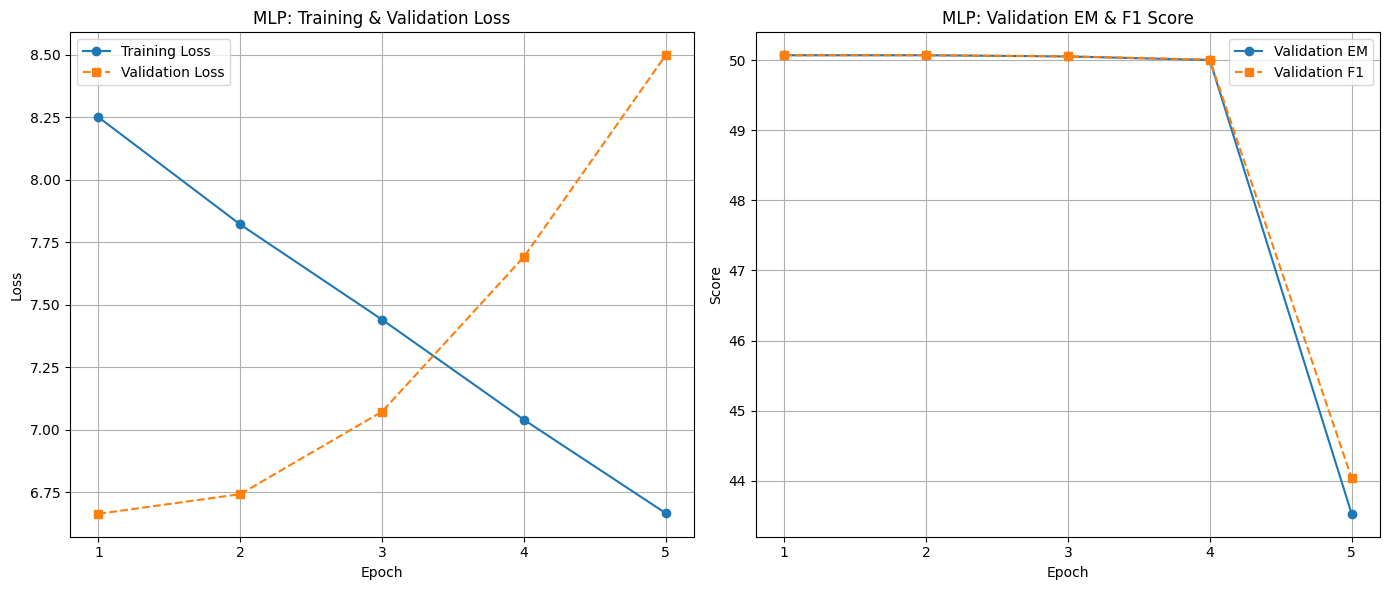

In [18]:
epochs_range_mlp = range(1, NUM_EPOCHS_MLP + 1)

plt.figure(figsize=(14, 6))

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range_mlp, mlp_history['train_loss'], marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs_range_mlp, mlp_history['val_loss'], marker='s', linestyle='--', label='Validation Loss')
plt.title('MLP: Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs_range_mlp)
plt.legend()
plt.grid(True)

# Plot 2: Validation EM and F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs_range_mlp, mlp_history['val_em'], marker='o', linestyle='-', label='Validation EM')
plt.plot(epochs_range_mlp, mlp_history['val_f1'], marker='s', linestyle='--', label='Validation F1')
plt.title('MLP: Validation EM & F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(epochs_range_mlp)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### **2.3.4 Why doesn't the MLP work well for SQuAD?**

The results perfectly illustrate *why* a simple MLP is unsuitable for this task:

1. **Lack of Contextual Understanding:** The MLP processes the input as a flattened sequence of token embeddings. It has no built-in mechanism to understand:
* The relationship between the question and the context.
* The meaning of words based on surrounding words (e.g., "bank" meaning a river bank vs. a financial institution).
* Long-range dependencies within the context passage.
* The sequential order of words beyond what the initial embedding might capture positionally.It essentially sees a long, jumbled list of features and tries to find a pattern to predict start/end indices, which is incredibly difficult without understanding the *meaning* conveyed by the sequence.

2. **Inability to Locate Spans:** Finding a specific answer *span* requires identifying relevant parts of the context based on the question and then pinpointing the precise start and end boundaries. The MLP's simple feed-forward structure isn't designed for this kind of pointer-like localization task based on semantic understanding. It struggles to assign high scores to the *correct* start and end tokens simultaneously based on the input features alone.

3. **Overfitting:** While the MLP learns the training data (loss decreases), the validation loss immediately increases. This suggests the patterns it learns are superficial and specific to the training examples, failing completely to generalize because it hasn't captured the underlying language understanding required for the task.




#### **2.3.5 Why is a Transformer (like DistilBERT/BERT) Needed?**

Transformers excel where the MLP fails due to their core **Self-Attention mechanism**:

1. **Contextual Embeddings:** Self-attention allows the model to look at all other words in the input (both question and context) when calculating the representation for a single word. This means the representation of a word is dynamically influenced by its context, capturing nuances in meaning.
2. **Question-Context Interaction:** Attention mechanisms enable the model to explicitly learn the relationships between question tokens and context tokens, identifying which parts of the context are most relevant to the question being asked.
3. **Sequence Modeling:** Transformers process the input sequentially (while allowing parallel computation) and inherently model the order and relationships between tokens over long distances.
4. **Pre-training:** Models like BERT and DistilBERT are pre-trained on massive amounts of text data. They already possess a strong general understanding of language structure, grammar, and world knowledge, which they can then adapt (fine-tune) specifically for the QA task much more effectively than an MLP starting from scratch.

#### **2.3.6 Why DistilBERT instead of BERT?**

While BERT (especially BERT-large) generally achieves higher accuracy on SQuAD than DistilBERT, we chose DistilBERT primarily for **efficiency**:

1. **Smaller Size:** DistilBERT has significantly fewer parameters than BERT-base (~66M vs. ~110M).
2. **Faster Training & Inference:** This smaller size translates directly to faster training times per epoch and quicker predictions (inference). This is crucial for projects with limited computational resources (like typical academic assignments or deployments on edge devices).
3. **Good Performance Trade-off:** DistilBERT retains a large percentage (often >95%) of BERT's performance on many tasks, including SQuAD, making it an excellent balance between speed/size and accuracy. For this project, achieving reasonable QA performance while keeping training times manageable was prioritized, making DistilBERT a suitable choice over the more resource-intensive BERT models.

### **2.4 Model Finalization and Advancements**

We finalize the model by **replacing the MLP with a pre-trained Transformer model specifically designed for Question Answering**, leveraging transfer learning. Following were the choices made to improve the model further by levearing a different archiecture and different techniques:

#### **2.4.1 Model Architecture**
Here, selected `DistilBertForQuestionAnswering` from the Hugging Face `transformers` library, using the `distilbert-base-cased` pre-trained weights. Following was the criteria for choosing this architecture:
*  Transformer architectures, with their self-attention mechanism, are the state-of-the-art for NLP tasks involving sequence understanding. They effectively model relationships between tokens, regardless of their distance in the sequence.
* Using `distilbert-base-cased` allows to leverage knowledge learned from a massive corpus during pre-training (Masked Language Modeling and Next Sentence Prediction). This significantly speeds up convergence and improves performance compared to training from scratch. `distilbert-base-cased` is chosen as a robust baseline; larger models like BERT or RoBERTa could be alternatives but require more computational resources. Other architectures such as RNNs/ LSTMs perform worse than Transformers on such sequence tasks.
* `DistilBertForQuestionAnswering` includes the base Distilled version of BERT model followed by a single linear layer that outputs two logits per token in the sequence: one representing the likelihood of that token being the *start* of the answer, and one for it being the *end*. This architecture is specifically tailored for extractive QA.
* `distilbert-base-cased` has 6 Transformer layers (encoder blocks), 12 attention heads per layer, and a hidden size of 768. The QA head is a linear layer mapping the final hidden states (shape `[batch_size, sequence_length, 768]`) to the start/end logits (shape `[batch_size, sequence_length, 2]`).



**Conceptual Summary of the model:**
1. Input: token_ids, attention_mask
2. DistilBERT Base ('distilbert-base-cased'): 6 layers of Transformer encoders.
   - Output: sequence_output (shape: [batch_size, seq_length, 768])
3. QA Head (Linear Layer + Reshape): Maps sequence_output to start/end logits.
   - Output: start_logits (shape: [batch_size, seq_length]), end_logits (shape: [batch_size, seq_length])

#### **2.4.2 Hyperparameter Tuning**

* **Learning Rate (LR):** `3e-5` (or `0.00003`). This is a common and generally effective learning rate for fine-tuning Distill BERT based models. It's small enough to avoid catastrophic forgetting of pre-trained knowledge but large enough for effective adaptation to the QA task. Values like `2e-5` or `5e-5` can be explored if needed, but `3e-5` is a strong starting point.

* **Batch Size:** `32`. This is often dictated by GPU memory constraints. Larger batch sizes can sometimes lead to more stable gradients and faster convergence *per epoch* but require more memory and might converge to sharper minima. Smaller batch sizes introduce more noise, which can sometimes help generalization. DistilBERT's smaller size allows for larger batch sizes compared to BERT-base on the same hardware, potentially leading to faster training per epoch.

* **Optimizer:** `AdamW`. This is the standard optimizer for training Transformers. It implements Adam with decoupled weight decay, which has been shown to be more effective than standard L2 regularization applied within the Adam algorithm. Reason for choosing `AdamW` compared to other optimizers:
  *   *AdamW vs Adam:* AdamW generally provides better generalization by correctly applying weight decay.
  *   *AdamW vs SGD/Momentum:* Adam-based optimizers typically converge much faster than SGD variants for complex models like Transformers, adapting the learning rate per parameter. While the previous experiments showed SGD/Momentum could work for the MLP, they are less common and often less efficient for fine-tuning large pre-trained models.

#### **2.4.3 Regularization Strategies**

* **Dropout:** Applied within the DistilBERT layers (dropout probability typically 0.1), as defined in the pre-trained model configuration. This helps prevent co-adaptation of neurons.

* **Weight Decay:** Applied via the `AdamW` optimizer (typical value `0.01`). This penalizes large weights, encouraging simpler models and reducing overfitting.

* **Layer Normalization:** Used within the Transformer blocks instead of Batch Normalization. It normalizes features across the hidden dimension for each sample independently, making it effective for variable-length sequences and generally preferred in Transformers. Batch Normalization is not typically used between Transformer layers.

#### **2.4.4 Overfitting Prevention**

* **Validation Split:** Using the official SQuAD v2 validation set (`validation_dataset`) to monitor performance during training and for model selection/early stopping.

* **Early Stopping:** Monitor validation loss or a key metric (like F1 score). Stop training if the validation metric ceases to improve for a predefined number of epochs (patience) to prevent overfitting and save computation.

* **Limited Epochs:** Fine-tuning typically requires only a few epochs (e.g., 2-5). Training for too long increases the risk of overfitting to the specific training examples.

#### **2.4.5 Learning Rate Schedulers:**

* Linear warmup followed by linear decay (`get_linear_schedule_with_warmup`).

* Start with a very small LR, gradually increase it to the target LR over a small number of "warmup" steps, and then decrease it linearly towards zero over the rest of training. This helps stabilize training, especially early on when gradients can be large and unstable due to the random initialization of the final QA layer.

#### **2.4.6 Advanced Techniques Included**

* **Transfer Learning / Pretrained Models:** **Yes.** We're using a model named `distilbert-base-cased`. The reason for this is that it helps the model work better and faster because it has already learned a lot from seeing tons of text before. We got this model from Hugging Face transformers
* **Attention Mechanisms:** **Yes.** Inside the DistilBERT model, there's self-attention. This is a key part of how Transformer models understand what words mean in relation to the other words around them. It's built right into how DistilBERT is made.
* **Knowledge Distillation:** **Yes.** The DistilBERT model we're using was actually created using a special trick called knowledge distillation. Someone took a much bigger and smarter model (called BERT) and taught a smaller model (DistilBERT) to act like it. This smart teaching happened before we even started using DistilBERT, but we still get the good results from it.

In [4]:
# Load the pre-trained DistilBERT model configured for Question Answering
model = DistilBertForQuestionAnswering.from_pretrained(MODEL_CHECKPOINT)
model.to(device)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [5]:
# Initialize AdamW optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Initialize Learning rate scheduler
num_training_steps = NUM_EPOCHS * len(train_dataloader)
num_warmup_steps = 200
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [6]:
print("Starting training and evaluation loop...")
# Lists to store metrics per epoch
history = {
    'train_loss': [],
    'val_loss': [],
    'val_em': [],
    'val_f1': []
}
early_stopping_counter = 0
best_val_loss = float('inf') # Initialize best validation loss to infinity (lower is better)
best_f1 = -1.0  # Initialize best F1 score
best_epoch_f1 = -1

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} Training", leave=False)

    for batch in train_progress_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            start_positions=start_positions,
            end_positions=end_positions
        )
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        lr_scheduler.step()

        running_train_loss += loss.item()
        train_progress_bar.set_postfix({'loss': loss.item()})

    average_train_loss = running_train_loss / len(train_dataloader)
    history['train_loss'].append(average_train_loss)

    # --- Evaluation Phase ---
    model.eval()
    running_val_loss = 0.0
    all_start_logits = []
    all_end_logits = []
    # We need to collect features' metadata again for this epoch's evaluation pass
    eval_features_metadata = { # Store metadata indexed by feature index
        "offset_mapping": [],
        "example_id": [],
        "sequence_ids": []
    }

    eval_progress_bar = tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} Evaluating", leave=False)
    with torch.no_grad():
        for batch_idx, batch in enumerate(eval_progress_bar):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            # Also pass labels to compute validation loss
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions, # Include labels for loss calculation
                end_positions=end_positions
            )

            # Accumulate validation loss
            running_val_loss += outputs.loss.item()

            # Store logits
            all_start_logits.append(outputs.start_logits.cpu().numpy())
            all_end_logits.append(outputs.end_logits.cpu().numpy())

            # Store metadata - IMPORTANT: Ensure batch items correspond to dataset items
            # We assume dataloader processes in order (shuffle=False)
            # Calculate the starting index in the dataset for this batch
            start_idx = batch_idx * validation_dataloader.batch_size
            end_idx = start_idx + len(batch["input_ids"]) # Handle last batch potentially smaller
            # Append metadata for items in this batch
            eval_features_metadata["offset_mapping"].extend(tokenized_validation[start_idx:end_idx]['offset_mapping'])
            eval_features_metadata["example_id"].extend(tokenized_validation[start_idx:end_idx]['example_id'])
            eval_features_metadata["sequence_ids"].extend(tokenized_validation[start_idx:end_idx]['sequence_ids'])

    # Concatenate logits and calculate average validation loss
    start_logits_epoch = np.concatenate(all_start_logits, axis=0)
    end_logits_epoch = np.concatenate(all_end_logits, axis=0)
    average_val_loss = running_val_loss / len(validation_dataloader)
    history['val_loss'].append(average_val_loss)

    # --- Postprocessing and Metric Calculation for the Epoch ---
    # Create a temporary features structure matching what postprocessing expects
    temp_features_for_postproc = {
        'offset_mapping': eval_features_metadata['offset_mapping'],
        'example_id': eval_features_metadata['example_id'],
        'sequence_ids': eval_features_metadata["sequence_ids"]
    }
    # Ensure the number of features matches the number of logits collected
    assert len(temp_features_for_postproc['example_id']) == len(start_logits_epoch), "Mismatch between features and logits count"

    predictions_epoch = postprocess_qa_predictions(
        validation_examples, # Original examples
        temp_features_for_postproc, # Feature metadata collected during eval
        start_logits_epoch,
        end_logits_epoch,
        N_BEST_SIZE,
        MAX_ANSWER_LENGTH
    )
    references_epoch = [{"id": ex["id"], "answers": ex["answers"]} for ex in validation_examples]

    # <<< ADD: Print first few predictions and references >>>
    print("\n--- Checking metric inputs (Epoch", epoch+1, ") ---")
    print("Sample Predictions (first 3):")
    for i in range(min(3, len(predictions_epoch))):
        print(predictions_epoch[i])
    print("\nSample References (first 3):")
    for i in range(min(3, len(references_epoch))):
        print(references_epoch[i])
    print("--- End metric input check ---\n")

    results_epoch = squad_v2_metric.compute(predictions=predictions_epoch, references=references_epoch)
    epoch_f1 = results_epoch['f1']
    epoch_em = results_epoch['exact']
    history['val_f1'].append(epoch_f1)
    history['val_em'].append(epoch_em)

    epoch_end_time = time.time()
    duration = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Time: {duration:.2f}s")
    print(f"  Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f}")
    print(f"  Val EM: {epoch_em:.4f} | Val F1: {epoch_f1:.4f}")

    # --- Save Best Model ---
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_epoch_f1 = epoch + 1 # Track epoch for best F1
        print(f"  ✨ New best F1 score found! Saving model to {BEST_MODEL_PATH}")
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        print(f"  (Best F1 so far: {best_f1:.4f} from epoch {best_epoch_f1})")

    # --- Early Stopping Check based on Validation Loss ---
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        early_stopping_counter = 0 # Reset counter because validation loss improved
        print(f"  Validation loss improved to {best_val_loss:.4f}. Resetting early stopping counter.")
    else:
        early_stopping_counter += 1
        print(f"  Validation loss did not improve for {early_stopping_counter} epoch(s).")
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n🛑 Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs without validation loss improvement.")
            break

print("\nTraining and evaluation finished.")
print(f"Best model saved from Epoch {best_epoch_f1} with F1 Score: {best_f1:.4f}")


Starting training and evaluation loop...


Epoch 1/10 Training:   0%|          | 0/4128 [00:00<?, ?it/s]

Epoch 1/10 Evaluating:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 7.2972

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=9.7454, Text='Denmark, Iceland and Norway'
    Rank 2: Score=7.6657, Text='Iceland and Norway'
    Rank 3: Score=7.2880, Text='Denmark, Iceland'
    Rank 4: Score=7.2379, Text='Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 5: Score=7.1592, Text='Denmark'
    Rank 6: Score=6.4119, Text='France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 7: Score=5.2083, Text='Iceland'
    Rank 8: Score=5.1465, Text='Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 9: Score=5.1012,

Epoch 2/10 Training:   0%|          | 0/4128 [00:00<?, ?it/s]

Epoch 2/10 Evaluating:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 7.4799

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=10.6287, Text='Denmark, Iceland and Norway'
    Rank 2: Score=6.8774, Text='Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 3: Score=6.5830, Text='Denmark'
    Rank 4: Score=6.4370, Text='Denmark, Iceland'
    Rank 5: Score=6.3050, Text='raiders and pirates from Denmark, Iceland and Norway'
    Rank 6: Score=6.1042, Text='Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 7: Score=5.8114, Text='Iceland and Norway'
    Rank 8: Score=5.4824, Text='France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark,

Epoch 3/10 Training:   0%|          | 0/4128 [00:00<?, ?it/s]

Epoch 3/10 Evaluating:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 4.7251

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=9.1447, Text='Denmark, Iceland and Norway'
    Rank 2: Score=5.9461, Text='Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 3: Score=5.8540, Text='Iceland and Norway'
    Rank 4: Score=5.8080, Text='France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 5: Score=4.8558, Text='Denmark, Iceland and Norway who'
    Rank 6: Score=4.2952, Text='raiders and pirates from Denmark, Iceland and Norway'
    Rank 7: Score=4.2222, Text='Denmark'
    Rank 8: Score=4.1611, Text='They were descended from Norse

Epoch 4/10 Training:   0%|          | 0/4128 [00:00<?, ?it/s]

Epoch 4/10 Evaluating:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 3.5289

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=9.2113, Text='Denmark, Iceland and Norway'
    Rank 2: Score=6.9388, Text='Iceland and Norway'
    Rank 3: Score=4.2793, Text='France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 4: Score=3.7923, Text='Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 5: Score=3.4372, Text='Denmark, Iceland and Norway who'
    Rank 6: Score=3.4025, Text='Denmark'
    Rank 7: Score=3.2033, Text='from Denmark, Iceland and Norway'
    Rank 8: Score=2.6891, Text='Denmark, Iceland'
    Rank 9: Score=1.8382, Text='

Epoch 5/10 Training:   0%|          | 0/4128 [00:00<?, ?it/s]

Epoch 5/10 Evaluating:   0%|          | 0/191 [00:00<?, ?it/s]

Postprocessing:   0%|          | 0/11873 [00:00<?, ?it/s]


--- Debugging Target Example ID: 56ddde6b9a695914005b962a ---
Ground Truth Answers: ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
  Feature 2: Null Score (CLS): 5.5014

  --- ALL Valid Candidate Answers Found for 56ddde6b9a695914005b962a (before sorting/filtering): ---
    Rank 1: Score=9.6698, Text='Denmark, Iceland and Norway'
    Rank 2: Score=7.4337, Text='Iceland and Norway'
    Rank 3: Score=5.3335, Text='Denmark'
    Rank 4: Score=4.3422, Text='France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 5: Score=3.9211, Text='from Denmark, Iceland and Norway'
    Rank 6: Score=3.7807, Text='Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'
    Rank 7: Score=3.6512, Text='Denmark, Iceland'
    Rank 8: Score=3.3431, Text='raiders and pirates from Denmark, Iceland and Norway'
    Rank 9:

## **3. Evaluation and Results**

### **3.1 Define and justify your chosen evaluation metrics:**

* **Primary metrics** used for evaluating the model on the SQuAD v2 task are:
  1. **Exact Match (EM):** This metric measures the percentage of predictions where the predicted answer text matches *exactly* with one of the ground-truth answer texts provided in the dataset. It is a strict, binary measure (1 for a perfect match, 0 otherwise).
  2. **F1 Score:** This metric calculates the harmonic mean of precision and recall at the token level, considering the overlap between the predicted answer tokens and the ground-truth answer tokens. It gives partial credit for predictions that largely overlap with the ground truth, even if they aren't exact matches (e.g., minor differences in punctuation or boundaries). F1 is generally considered a more comprehensive measure for extractive QA than EM alone.
  * EM and F1 are the standard and official metrics for the SQuAD benchmark. Using them ensures comparability with published results and provides a standard way to assess performance. EM measures strict accuracy, while F1 provides a more granular view of the prediction quality, accounting for partial correctness. The `evaluate` library's `squad_v2` metric implementation correctly handles the calculation for both, including the specific logic for unanswerable questions (where predicting an empty string `""` when the ground truth is unanswerable counts as correct).
* **Secondary Metric** used for monitoring training and stopping criteria:
  * **Validation Loss (Cross-Entropy):** While not a final performance metric, the cross-entropy loss on the validation set was monitored during training. It reflects how well the model's predicted start/end logit distributions match the true distributions. It was used for the early stopping criterion because it's often a smoother and more direct indicator of model generalization compared to the non-differentiable EM/F1 scores.



### **3.2 Use a proper train/validation/test split or cross-validation:**



* The standard SQuAD v2 dataset splits provided by Hugging Face (`datasets` library) were used:
  * `train` split: Used exclusively for training the model parameters.
  * `validation` split: Used exclusively for evaluating the model after each epoch to monitor performance, select the best model checkpoint (based on F1 score), and implement early stopping (based on validation loss).
* Using the predefined official splits for the mentioned dataset is crucial for:
  * **Preventing Data Leakage:** Ensures the model is evaluated on data it has never seen during training.
  * **Comparability:** Allows results to be compared fairly with other research and models evaluated on the same benchmark splits.
  * **No Cross-Validation requirement:** Cross-validation is generally not standard practice for large datasets like SQuAD combined with computationally intensive models like Transformers, due to the high training cost. The single, large validation split (11,000+ examples) is considered sufficient.
* For this project, the official `validation` split served as the final **test set** for reporting performance, as the official SQuAD test set is typically hidden and used for leaderboard submissions.

### **3.3 Reporting validation performance**

#### **3.3.1 Learning Curves**

The provided graphs visually represent the model's learning dynamics over 5 epochs.
* **Loss Curve (Left Graph):**
  * *Training Loss (Blue, Solid):* Shows a consistent and steep decrease from ~1.74 down to ~0.57 across the 5 epochs. This indicates the model is effectively learning patterns from the training data.
  * *Validation Loss (Orange, Dashed):* Decreases sharply from Epoch 1 (\~1.32) to Epoch 2 (\~1.28), indicating initial generalization. However, it then starts to **increase** from Epoch 3 onwards (~1.43 -> ~1.54 -> ~1.73), clearly signaling the onset of **overfitting**. The model starts fitting the training data too closely at the expense of performance on unseen validation data. The minimum validation loss occurred at Epoch 2.
* **Accuracy/Score Curve (Right Graph):**
  * *Validation EM (Blue, Solid):* Increases rapidly from ~60.2 at Epoch 1 to ~63.8 at Epoch 2, then continues to increase more slowly, plateauing around ~64.6 from Epoch 4 onwards.
  * *Validation F1 (Orange, Dashed):* Shows a similar trend but consistently higher than EM. It increases sharply from ~62.9 at Epoch 1 to ~66.3 at Epoch 2, and continues to improve, reaching its peak around ~68.0 at Epoch 5 in this specific visualization (though logs indicate the best saved F1 was ~68.0 at Epoch 5, the peak might have been slightly earlier or later depending on exact values). The gap between F1 and EM is expected and healthy.
* The logs confirm that early stopping (monitoring validation loss with patience=3) triggered after Epoch 5, as the validation loss did not improve in epochs 3, 4, and 5 compared to epoch 2.

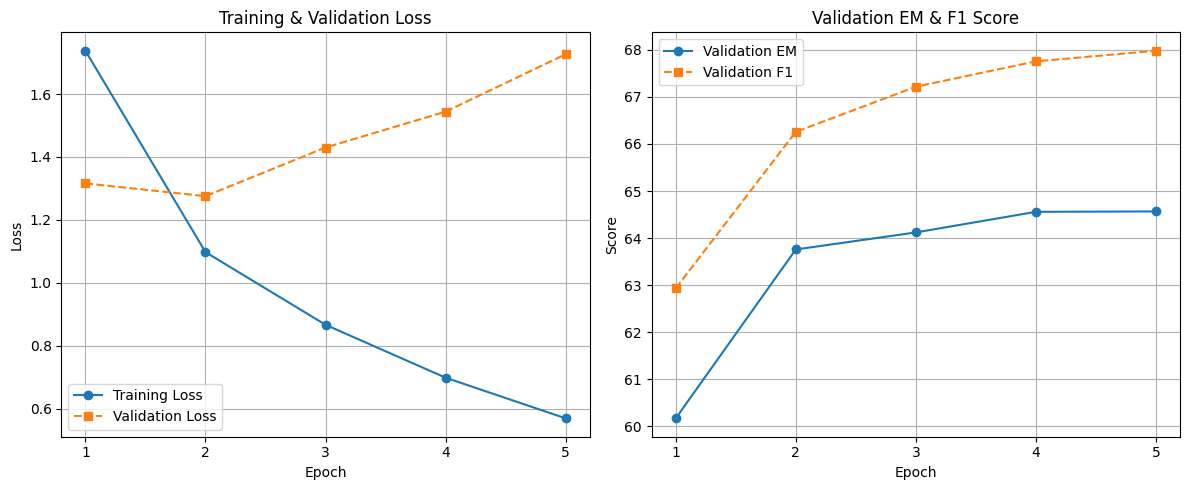

In [7]:
# Visualizations

epochs_range = range(1, min(NUM_EPOCHS + 1, len(history['train_loss']) + 1))

# Plot 1: Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs_range, history['val_loss'], marker='s', linestyle='--', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)

# Plot 2: Validation EM and F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['val_em'], marker='o', linestyle='-', label='Validation EM')
plt.plot(epochs_range, history['val_f1'], marker='s', linestyle='--', label='Validation F1')
plt.title('Validation EM & F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### **3.3.2 Confusion Matrix**
* A standard confusion matrix comparing predicted classes (e.g., class A vs. class B) is **not applicable** to extractive Question Answering. The output is a text span, not a fixed category.
* However, this is not a standard SQuAD evaluation practice and is generally less informative than EM/F1 scores, which directly assess the quality of the extracted answer span. Therefore, no confusion matrix is included.

#### **3.3.3 ROC or Precision-Recall Curves**
* These curves are also **not applicable** to standard extractive QA. They are used for binary (or multi-class) classification tasks where a decision threshold on a model's output probability can be varied.
* In extractive QA, the prediction is typically derived using `argmax` on the start/end logits to get discrete token indices, not by thresholding a probability score.

#### **3.3.4 Qualitative or domain-specific visualizations**

The provided **Qualitative Examples from Best Model (Epoch 5)** serve this purpose:

* **Example 1:** Success - Correctly identifies an unanswerable question (`[IMPOSSIBLE]`).
* **Example 2:** Success - Correctly extracts the exact answer (`Lothar de Maizière`).
* **Example 3:** Failure - Incorrectly predicts `[IMPOSSIBLE]` when the answer was `complexity classes`. This highlights a key challenge in SQuAD v2 – distinguishing answerable from unanswerable.
* **Example 4:** Success - Correctly extracts one of the possible ground-truth answers (`GTE`).
* **Example 5:** Success - Correctly identifies an unanswerable question (`[IMPOSSIBLE]`).

In [8]:
# Qualitative / Domain-Specific Visualizations
print(f"\nLoading best model from epoch {best_epoch_f1} for qualitative examples...")
if os.path.exists(BEST_MODEL_PATH):
    # Load the best model state
    best_model = DistilBertForQuestionAnswering.from_pretrained(MODEL_CHECKPOINT) # Re-initialize
    best_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    best_model.to(device)
    best_model.eval()

    print("\n--- Qualitative Examples from Best Model ---")
    num_qual_examples = 5
    num_qual_examples = min(num_qual_examples, len(validation_examples))

    if num_qual_examples > 0:
        # Sample random examples from the evaluated subset
        sampled_indices = random.sample(range(len(validation_examples)), k=num_qual_examples)
        sampled_examples = [validation_examples[i] for i in sampled_indices]
        sampled_example_ids = [ex['id'] for ex in sampled_examples]

        # Find the features corresponding to these examples in the validation subset
        sampled_features = tokenized_validation.filter(lambda feature: feature['example_id'] in sampled_example_ids)

        # Prepare dataloader for just these features
        sampled_dataloader = DataLoader(sampled_features, batch_size=BATCH_SIZE * 2) # Use larger batch size

        # Run inference with the best model
        qual_start_logits = []
        qual_end_logits = []
        qual_features_metadata = {
             "offset_mapping": [],
             "example_id": [],
             'sequence_ids': []
        }

        with torch.no_grad():
            for batch_idx, batch in enumerate(sampled_dataloader):
                 input_ids = batch["input_ids"].to(device)
                 attention_mask = batch["attention_mask"].to(device)
                 outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
                 qual_start_logits.append(outputs.start_logits.cpu().numpy())
                 qual_end_logits.append(outputs.end_logits.cpu().numpy())

                 # Store metadata corresponding to this batch from sampled_features
                 start_idx = batch_idx * sampled_dataloader.batch_size
                 end_idx = start_idx + len(batch["input_ids"])
                 qual_features_metadata["offset_mapping"].extend(sampled_features[start_idx:end_idx]['offset_mapping'])
                 qual_features_metadata["example_id"].extend(sampled_features[start_idx:end_idx]['example_id'])
                 qual_features_metadata["sequence_ids"].extend(sampled_features[start_idx:end_idx]['sequence_ids'])


        # Concatenate logits
        qual_start_logits_np = np.concatenate(qual_start_logits, axis=0)
        qual_end_logits_np = np.concatenate(qual_end_logits, axis=0)

        # Create temporary features structure for postprocessing
        temp_qual_features = {
            'offset_mapping': qual_features_metadata['offset_mapping'],
            'example_id': qual_features_metadata['example_id'],
            'sequence_ids': qual_features_metadata['sequence_ids']
        }
        assert len(temp_qual_features['example_id']) == len(qual_start_logits_np), "Mismatch in qualitative features/logits"


        # Run postprocessing on the sampled examples/features
        qual_predictions = postprocess_qa_predictions(
            sampled_examples, # Pass only the sampled original examples
            temp_qual_features, # Pass only the metadata for the features of sampled examples
            qual_start_logits_np,
            qual_end_logits_np,
            N_BEST_SIZE,
            MAX_ANSWER_LENGTH
        )
        qual_predictions_dict = {p['id']: p['prediction_text'] for p in qual_predictions}

        # Display results
        for i, example in enumerate(sampled_examples):
            example_id = example['id']
            question = example['question']
            context = example['context']
            true_answers = example['answers']['text']
            is_unanswerable = len(true_answers) == 0
            predicted_answer = qual_predictions_dict.get(example_id, "[PREDICTION NOT FOUND]")

            print(f"\n--- Example {i+1} (ID: {example_id}) ---")
            print(f"Q: {question}")
            print(f"Context (snippet): {context[:512]}...") # Show context snippet
            print(f"True Ans: {'[IMPOSSIBLE]' if is_unanswerable else true_answers}")
            # Display predicted answer, marking empty string as impossible
            print(f"Pred Ans (Best Model): {predicted_answer if predicted_answer else '[IMPOSSIBLE]'}")

            # Optional: Show input tokens (can be long)
            # Find one feature for this example to show tokens
            # feature_idx = qual_features_metadata['example_id'].index(example_id) # Find first feature index
            # input_tokens = tokenizer.convert_ids_to_tokens(sampled_features[feature_idx]['input_ids'])
            # print(f"Input Tokens (Truncated): {' '.join(input_tokens[:50])}...")
            print("-" * 20)

    else:
        print("Not enough examples in the validation subset to show qualitative results.")
else:
    print(f"Error: Best model file not found at {BEST_MODEL_PATH}. Cannot show qualitative examples.")


Loading best model from epoch 5 for qualitative examples...


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Qualitative Examples from Best Model ---


Filter:   0%|          | 0/12199 [00:00<?, ? examples/s]

Postprocessing:   0%|          | 0/5 [00:00<?, ?it/s]


--- Example 1 (ID: 5ad031ef77cf76001a686df5) ---
Q: When did French Republicans back building the English empire?
Context (snippet): France took control of Algeria in 1830 but began in earnest to rebuild its worldwide empire after 1850, concentrating chiefly in North and West Africa, as well as South-East Asia, with other conquests in Central and East Africa, as well as the South Pacific. Republicans, at first hostile to empire, only became supportive when Germany started to build her own colonial empire. As it developed, the new empire took on roles of trade with France, supplying raw materials and purchasing manufactured items, as well...
True Ans: [IMPOSSIBLE]
Pred Ans (Best Model): [IMPOSSIBLE]
--------------------

--- Example 2 (ID: 57111b95a58dae1900cd6c53) ---
Q: Who was the final Prime Minister of East Germany?
Context (snippet): Frederick William, Elector of Brandenburg, invited Huguenots to settle in his realms, and a number of their descendants rose to positions of promine

### **3.4 Interpretation of results and model behaviour**
The model's behavior aligns well with expectations for fine-tuning a DistilBERT model on SQuAD v2.
*   It demonstrates learning (decreasing training loss).
*   It shows initial generalization followed by overfitting (U-shaped validation loss curve).
*   It achieves performance metrics (Peak F1 ~68) consistent with DistilBERT's known capabilities (trading some accuracy for efficiency compared to larger models).
*   The relationship F1 >= EM holds true after the initial epoch.
*   The early stopping mechanism correctly identifies the overfitting point based on validation loss and terminates training.


### **3.5 Success Cases**
* The model successfully learned to extract exact answers for many questions (indicated by EM score > 60 and qualitative examples 2 & 4).
* It also learned to identify a significant portion of unanswerable questions (indicated by the relatively high EM/F1 scores, which require correct handling of unanswerable cases, and qualitative examples 1 & 5).
* The post-processing logic correctly selects the best span and compares it to the null answer threshold.

### **3.6 Potential Limitations**

Following are the limitations observed for the model:
* **Overfitting:** The model starts overfitting relatively early (after epoch 2). While early stopping prevents further degradation, the absolute peak performance might be limited by this tendency. The chosen hyperparameters (especially batch size 64) might contribute to this.
* **DistilBERT Capacity:** The peak F1 score of ~68, while respectable for DistilBERT, is significantly lower than state-of-the-art models (often in the high 80s or low 90s F1). This reflects the inherent capacity limitation of the smaller distilled model. It may struggle with questions requiring very complex reasoning or understanding subtle nuances in long contexts.
* **Misclassification of Answerability:** Qualitative example 3 shows the model still incorrectly identifies some answerable questions as unanswerable. This remains a key challenge on SQuAD v2. Conversely, it might also incorrectly provide answers for unanswerable questions (though not shown in this sample).
* **Sensitivity to Hyperparameters:** Performance is sensitive to hyperparameters (LR, batch size, weight decay, etc.), and while the current set yields reasonable results, further tuning (as discussed previously, e.g., smaller batch size) might yield marginal improvements.